In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Concatenate,Layer,Lambda,Input,Multiply,SimpleRNN,GRU,ReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
Loc = np.asarray(np.linspace(0,53,54)) 

In [3]:
def create_dataset(ns, fname, look_back=1):
    dataX, dataY = [], []
    for c in ns:
        dataframe = pandas.read_csv(fname, usecols=[int(c)], engine='python')
        dataframe.dropna(how='all',inplace=True)
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        for i in range(len(dataset)-look_back):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_dataset3(ns, fname, totalPop, look_back=1):
    dataX, dataY,sD = [], [], []
    for c in ns:
        pop = totalPop[int(c)]
        dataframe = pandas.read_csv(fname, usecols=[int(c)], engine='python')
        dataframe.dropna(how='all',inplace=True)
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        dataset /= pop
        for i in range(len(dataset)-look_back):
            a = dataset[i:(i+look_back), 0]
            meanA = np.mean(a)
            
            b = dataset[i + look_back, 0]
            if meanA > 0:
                a = a/meanA
                b = b/meanA
            dataX.append(a)
            sD.append(meanA)
            dataY.append(b)
    return np.array(dataX), np.array(dataY), np.array(sD)

In [4]:

dataframePop = pandas.read_csv('TotalPop.csv', engine='python')
datasetPop = dataframePop.values
datasetPop = datasetPop.astype('float32')
totalPop = datasetPop[0,:]

lb = 7


trainActive, targetActive, activeS = create_dataset3(Loc,'Active_cases_data.csv',totalPop,lb)

trainTotal, targetTotal, totalS = create_dataset3(Loc,'Total_cases_data.csv',totalPop,lb)

train1d, target1d, one_dayS = create_dataset3(Loc,'One-day-change_data.csv',totalPop,lb)

train2d, target2d, three_dayS = create_dataset3(Loc,'Three-day-change_data.csv',totalPop,lb)

train3d, target3d, seven_dayS = create_dataset3(Loc,'Seven-day-change_data.csv',totalPop,lb)

trainPop, targetPop = create_dataset(Loc,'Pop_data.csv',lb)
maxPop = np.max(targetPop)
minPop = np.min(trainPop)
trainPop = (trainPop - minPop)/(maxPop - minPop)
targetPop = (targetPop - minPop)/(maxPop - minPop)

trainMed, targetMed = create_dataset(Loc,'Med_data.csv',lb)
maxMed = np.max(targetMed)
minMed = np.min(trainMed)
trainMed = (trainMed - minMed)/(maxMed - minMed)
targetMed = (targetMed - minMed)/(maxMed - minMed)

In [5]:
sql = trainActive.shape[0]
trainX = np.concatenate((np.reshape(trainActive,(sql,lb,1)),np.reshape(trainTotal,(sql,lb,1)),np.reshape(train1d,(sql,lb,1)),np.reshape(train2d,(sql,lb,1)),np.reshape(train3d,(sql,lb,1)),np.reshape(trainPop,(sql,lb,1)),np.reshape(trainMed,(sql,lb,1))),axis=2)
#trainX = np.concatenate((np.reshape(trainActive,(sql,lb,1)),np.reshape(trainTotal,(sql,lb,1)),np.reshape(trainPop,(sql,lb,1)),np.reshape(trainMed,(sql,lb,1))),axis=2)

trainY = np.concatenate((np.reshape(targetActive,(sql,1)),np.reshape(targetTotal,(sql,1))),axis=1)

In [6]:
numR = 1
fcl = 90

totalPredict = np.zeros((1,fcl))
activePredict = np.zeros((1,fcl))

for m_run in range(numR):
    print(m_run)
    # create and fit the LSTM network
    numF = 2
    numF2 = 7

    AllInput = Input(shape=(lb,numF2))
    RecInput = Lambda(lambda AllInput:AllInput[:,:,:numF],name='RecIn')(AllInput)
    HidInput = Lambda(lambda AllInput:AllInput[:,-1,numF:],name='HIn')(AllInput)
    H = LSTM(20, input_shape=(lb,numF))(RecInput)
    D2 = Dense(20,activation='sigmoid')(HidInput)
    Data = Concatenate()([H,D2])
    out = Dense(2)(Data)
    
    #H = LSTM(20, input_shape=(lb,numF))(RecInput)
    #D2 = Dense(20,activation='sigmoid')(HidInput)
    #Data = Concatenate()([H,D2])
    #D3 = Dense(20,activation='sigmoid')(Data)
    #out1 = Dense(2)(D3)
    #out = ReLU(max_value = 2)(out1

    CoVid = Model(AllInput,out)
    #CoVid.summary()
    CoVid.compile(loss='mean_squared_error', optimizer='adam')
    CoVid.fit(trainX, trainY, epochs=100, batch_size=50, verbose=1)

    BexarPop = 1975000
    testPop =  1553
    testMed =  (7839./BexarPop)*10000

    testPop = (testPop - minPop)/(maxPop - minPop)

    testMed = (testMed - minMed)/(maxMed - minMed)
    
    testActive = np.asarray([29,29,39,45,56,68,81])/BexarPop
    testTotal = np.asarray([29,29,39,45,57,69,84])/BexarPop
    test1d = np.asarray([4,0,10,6,12,12,15])/BexarPop
    test2d = np.asarray([29,29,14,16,28,30,39])/BexarPop
    test3d = np.asarray([29,29,39,45,57,69,84])/BexarPop
    
    meanA = np.mean(testActive)
    meanT = np.mean(testTotal)
    mean1d = np.mean(test1d)
    mean2d = np.mean(test2d)
    mean3d = np.mean(test3d)
    
    testActive /= meanA
    testTotal /= meanT
    test1d /= mean1d
    test2d /= mean2d
    test3d /= mean3d 
    

    f1 = np.reshape(testActive,(1,lb,1))
    f2 = np.reshape(testTotal,(1,lb,1))
    f3 = np.reshape(test1d,(1,lb,1))
    f4 = np.reshape(test2d,(1,lb,1))
    f5 = np.reshape(test3d,(1,lb,1))
    f6 = np.reshape([testPop,testPop,testPop,testPop,testPop,testPop,testPop],(1,lb,1))
    f7 = np.reshape([testMed,testMed,testMed,testMed,testMed,testMed,testMed],(1,lb,1))

    totalPredictT = np.zeros((1,fcl))
    activePredictT = np.zeros((1,fcl))
    
    totalGT = np.asarray([25,29,29,39,45,57,69,84])
    activeGT = np.asarray([25,29,29,39,45,56,68,81])
    
    initX = np.concatenate((f1,f2,f3,f4,f5,f6,f7),axis=2)
    for tp in range(fcl):
        prevX = initX
        oi = prevX[0,1:,:]
        singlePredict = CoVid.predict(initX)
        
        prevT7 = prevX[0,0,1]
        
        prevT3 = prevX[0,4,1]
        
        prevT1 = prevX[0,-1,1]
        
        currentT = np.float32(singlePredict[0][1])
        
        f3 = currentT - prevT1
        f4 = currentT - prevT3
        f5 = currentT - prevT7
        
        ci = np.reshape(prevX[0,-1,5:],(1,2))
        di = np.reshape(np.asarray([f3,f4,f5]),(1,3))
        completeIn = np.concatenate((singlePredict,di,ci),axis=1)
        initXt = np.concatenate((oi,completeIn),axis=0)
        initXt = np.reshape(initXt,(1,lb,numF2))
        
        totalPredictT[0,tp] = np.float32(singlePredict[0][1])*meanT
        activePredictT[0,tp] = np.float32(singlePredict[0][0])*meanA
        
        t1 = initXt[0,:,0]
        t1 *= meanA
        meanA = np.mean(t1)
        t1 /= meanA
        t1 = np.reshape(t1,(lb,1))
        
        t2 = initXt[0,:,1]
        t2 *= meanT
        meanT = np.mean(t2)
        t2 /= meanT
        t2 = np.reshape(t2,(lb,1))
        
        t3 = initXt[0,:,2]
        t3 *= mean1d
        mean1d = np.mean(t3)
        t3 /= mean1d
        t3 = np.reshape(t3,(lb,1))
        
        t4 = initXt[0,:,3]
        t4 *= mean2d
        mean2d = np.mean(t4)
        t4 /= mean2d
        t4 = np.reshape(t4,(lb,1))
        
        t5 = initXt[0,:,4]
        t5 *= mean3d
        mean3d = np.mean(t5)
        t5 /= mean3d
        t5 = np.reshape(t5,(lb,1))
        
        t6 = initXt[0,:,5]
        t6 = np.reshape(t6,(lb,1))
        
        t7 = initXt[0,:,6]
        t7 = np.reshape(t7,(lb,1))
        
        initX = np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=1)
        initX = np.reshape(initX,(1,lb,numF2))
        
    totalPredict = totalPredict + totalPredictT/numR
    activePredict = activePredict + activePredictT/numR
    

0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3078/3078 [==============================] - 4s 1ms/step - loss: 4.3467
Epoch 2/100
3078/3078 [==============================] - 1s 386us/step - loss: 3.1239
Epoch 3/100
3078/3078 [==============================] - 1s 387us/step - loss: 2.7346
Epoch 4/100
3078/3078 [==============================] - 1s 388us/step - loss: 2.3161
Epoch 5/100
3078/3078 [==============================] - 1s 389us/step - loss: 2.0307
Epoch 6/100
3078/3078 [==============================] - 1s 383us/step - loss: 1.9069
Epoch 7/100
3078/3078 [==============================] - 1s 388us/step - loss: 1.8245
Epoch 8/100
3078/3078 [==============================] - 1s 385us/step - loss: 1.7660
Epoch 9/100
3078/3078 [==============================] - 1s 385us/step - loss: 1.7152
Epoch 10/100
3078/3078 [==============================] - 1s 383us/step - loss: 1.6822
Epoch 11/100
3078/3

3078/3078 [==============================] - 1s 388us/step - loss: 1.3960
Epoch 90/100
3078/3078 [==============================] - 1s 386us/step - loss: 1.4028
Epoch 91/100
3078/3078 [==============================] - 1s 385us/step - loss: 1.3938
Epoch 92/100
3078/3078 [==============================] - 1s 386us/step - loss: 1.4037
Epoch 93/100
3078/3078 [==============================] - 1s 386us/step - loss: 1.3934
Epoch 94/100
3078/3078 [==============================] - 1s 385us/step - loss: 1.3953
Epoch 95/100
3078/3078 [==============================] - 1s 384us/step - loss: 1.3981
Epoch 96/100
3078/3078 [==============================] - 1s 386us/step - loss: 1.3984
Epoch 97/100
3078/3078 [==============================] - 1s 390us/step - loss: 1.3916
Epoch 98/100
3078/3078 [==============================] - 1s 387us/step - loss: 1.3917
Epoch 99/100
3078/3078 [==============================] - 1s 385us/step - loss: 1.3924
Epoch 100/100
3078/3078 [==============================]

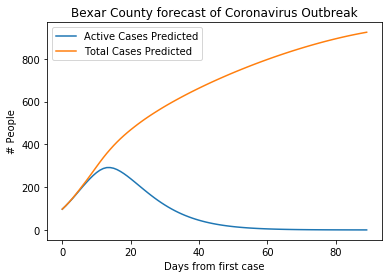

In [7]:
plt.plot((activePredict[0,:])*BexarPop)
plt.plot((totalPredict[0,:])*BexarPop)
plt.xlabel('Days from first case')
plt.ylabel('# People')
plt.title('Bexar County forecast of Coronavirus Outbreak')
plt.legend(['Active Cases Predicted','Total Cases Predicted'])
plt.show()

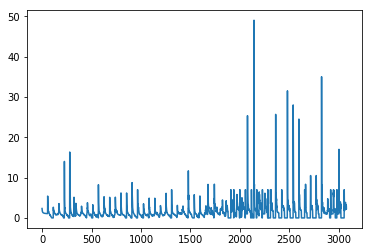

In [8]:
plt.plot(targetActive)
plt.show()